### Resets all variables in the workspace

In [59]:
%reset -f

### Importing necessary libraries

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import spacy
from collections import Counter
import yfinance as yf

### Declaring functions

In [3]:
#Function that reads all the pickle files in a folder, returns list of file names.
def read_file_names(folder_path: str) -> list:
    files = [f for f in os.listdir(folder_path) if f.endswith('.p')]
    return files

In [4]:
def extract_data(folder_path: str, ticker: str) -> list:
    file_path = os.path.join(folder_path, ticker)  #File path.

    with open(file_path, 'rb') as file:  #Open file.
        content = pickle.load(file)  #Load content.
        data = []  #Create empty list.

        for entry in content:  #Iterate over the content.
            data.append(entry)  #Collect the dictionary.

    return data  #Return the list of dictionaries.

In [5]:
def extract_and_process_transcripts(transcripts: list[dict]) -> tuple:
    transcripts_texts = []
    times = []

    for t in transcripts:
        text = ''.join([speech['speech'][0] for speech in t['transcript']])
        transcripts_texts.append(text)
        times.append(t['time'])

    return transcripts_texts, times

In [6]:
def define_LM(LM_file: str) -> tuple:
    LM_negative = pd.read_excel(LM_file, sheet_name='Negative', header=None)
    LM_positive = pd.read_excel(LM_file, sheet_name='Positive', header=None)
    LM_uncertainty = pd.read_excel(LM_file, sheet_name='Uncertainty', header=None)

    LM_positive_list = LM_positive.squeeze().tolist()
    LM_negative_list = LM_negative.squeeze().tolist()
    LM_uncertainty_list = LM_uncertainty.squeeze().tolist()

    # Process the word lists using simple string methods
    LM_positive_set = set(word.lower() for word in LM_positive_list)
    LM_negative_set = set(word.lower() for word in LM_negative_list)
    LM_uncertainty_set = set(word.lower() for word in LM_uncertainty_list)

    return LM_positive_set, LM_negative_set, LM_uncertainty_set

In [7]:
def process_texts(texts, nlp):
    # Limit the length of each text to 20,000 characters
    texts = [text[:20000] if len(text) > 20000 else text for text in texts]
    
    # Use nlp.pipe for efficient batch processing
    docs = nlp.pipe(texts, disable=['parser', 'ner', 'textcat'])

    processed_texts = []
    for doc in docs:
        words = [token.lemma_.lower() for token in doc if not (token.is_space or token.is_stop or token.is_punct)]
        processed_texts.append(words)

    return processed_texts

In [8]:
def score_transcripts(processed_texts, LM_positive_set, LM_negative_set, LM_uncertainty_set):
    sentiment_scores = []

    for words in processed_texts:
        number_of_words = len(words)
        counts = Counter(words)
        keys = set(counts.keys())

        pos = round((sum(counts[k] for k in (keys & LM_positive_set)) / number_of_words), 4)
        neg = round((sum(counts[k] for k in (keys & LM_negative_set)) / number_of_words), 4)
        unc = round((sum(counts[k] for k in (keys & LM_uncertainty_set)) / number_of_words), 4)

        sentiment_scores.append((pos, neg, unc))

    return sentiment_scores

In [9]:
def analysis(in_data: list, ticker_names: list, nlp: spacy.lang, LM_positive_set: set, LM_negative_set: set, LM_uncertainty_set: set) -> pd.DataFrame:
    # Initialize data structures
    data_records = []
    ticker_start_dates = {}
    transcripts_dict = {}  # To store transcripts and times for each company

    # Step 1: Process each company and collect transcripts, times, and update ticker_start_dates
    for tic, company in enumerate(in_data):
        # Call extract_and_process_transcripts once per company
        transcripts, times = extract_and_process_transcripts(company)
        ticker = ticker_names[tic]

        # Store transcripts and times for later use
        transcripts_dict[ticker] = {'transcripts': transcripts, 'times': times}

        # Convert times to datetime
        times_dt = pd.to_datetime(times)
        earliest_date = times_dt.min() - pd.Timedelta(days=1)
        start_date = earliest_date.strftime('%Y-%m-%d')

        # Update earliest start date per ticker
        if ticker not in ticker_start_dates or pd.to_datetime(start_date) < pd.to_datetime(ticker_start_dates[ticker]):
            ticker_start_dates[ticker] = start_date

    # Step 2: Batch download market data for all tickers
    market_data_all = {}
    for ticker, start_date in ticker_start_dates.items():
        market_data = yf.download(ticker, start=start_date, progress=False)
        if market_data.empty:
            continue
        market_data['returns'] = market_data['Adj Close'].diff()
        market_data = market_data[['Adj Close', 'returns']].dropna()
        market_data.index = pd.to_datetime(market_data.index)
        market_data_all[ticker] = market_data

    # Step 3: Process data using the pre-downloaded market data
    for ticker in transcripts_dict:
        transcripts = transcripts_dict[ticker]['transcripts']
        times = transcripts_dict[ticker]['times']
        market_data = market_data_all.get(ticker, pd.DataFrame())

        # Create DataFrame for transcripts and times
        df_transcripts = pd.DataFrame({
            'date': pd.to_datetime(times).strftime('%Y-%m-%d'),
            'transcript': transcripts
        })
        df_transcripts['ticker'] = ticker

        # Process transcripts using nlp.pipe
        processed_texts = process_texts(df_transcripts['transcript'].tolist(), nlp)

        # Score transcripts
        sentiment_scores = score_transcripts(processed_texts, LM_positive_set, LM_negative_set, LM_uncertainty_set)
        df_transcripts[['pos', 'neg', 'unc']] = pd.DataFrame(sentiment_scores, index=df_transcripts.index)
        df_transcripts['net_sentiment'] = df_transcripts['pos'] - df_transcripts['neg']

        # Merge with market data
        if not market_data.empty:
            market_data = market_data.reset_index()
            market_data['date'] = market_data['Date'].dt.strftime('%Y-%m-%d')
            market_data = market_data[['date', 'Adj Close', 'returns']]
            df_merged = pd.merge(df_transcripts, market_data, on='date', how='left')
        else:
            df_merged = df_transcripts.copy()
            df_merged['Adj Close'] = None
            df_merged['returns'] = None

        # Append to data_records
        data_records.append(df_merged[::-1])

    # Concatenate all data into one DataFrame
    df_all = pd.concat(data_records, ignore_index=True)

    # Select and reorder columns
    df_all = df_all[['date', 'ticker', 'net_sentiment', 'pos', 'neg', 'unc', 'Adj Close', 'returns']]

    return df_all

In [10]:
def group_by_sector(dataframe: pd.DataFrame, sector: str, sector_groups: dict) -> pd.DataFrame:
    df_sector = dataframe[dataframe['ticker'].isin(sector_groups[sector])]
    return df_sector

### Main function

In [13]:
if __name__ == '__main__':
    folder_path = 'tickers'  # Path to the folder containing the pickle files.
    file_names = read_file_names(folder_path)  # List of all the pickle files in the folder.
    tickers = [ticker[:-2] for ticker in file_names]  # List of all the tickers.
    in_data = []  # Initialize an empty list to store the transcripts.

    # Load the spaCy model and disable unnecessary pipeline components
    nlp = spacy.load('en_core_web_md', disable=['parser', 'ner', 'textcat'])

    # Loop through all files and extract transcripts.
    for file in file_names:
        transcripts = extract_data(folder_path, file)  # Extract the transcripts.
        in_data.append(transcripts)  # Append the transcripts to the list.

    LM_file = 'LoughranMcDonald_SentimentWordLists_2018.xlsx'
    LM_positive_set, LM_negative_set, LM_uncertainty_set = define_LM(LM_file)

    df_tickers = analysis(in_data, tickers, nlp, LM_positive_set, LM_negative_set, LM_uncertainty_set)

    sector_groups = pd.DataFrame({
        'communication_services': ['CHTR', 'CMCSA', 'DIS', None, None, None, None, None, None],
        'consumer_cyclical':      ['BKNG', 'LOW', 'MCD', 'NKE', 'SE', None, None, None, None],
        'consumer_defensive':     ['PEP', 'PM', 'TGT', None, None, None, None, None, None],
        'energy':                 ['CVX', 'XOM', None, None, None, None, None, None, None],
        'financial_services':     ['AXP', 'BX', 'C', 'JPM', 'MA', 'MCO', 'TD', None, None],
        'healthcare':             ['ABBV', 'ABT', 'AZN', 'CVS', 'LLY', 'NVO', 'SNY', None, None],
        'industrials':            ['BA', 'HON', 'UNP', 'UPS', None, None, None, None, None],
        'technology':             ['AAPL', 'AMD', 'CRM', 'IBM', 'INTC', 'MSFT', 'ORCL', 'SAP', 'TXN']
    })

    df_communication_services = group_by_sector(df_tickers, 'communication_services', sector_groups)
    df_consumer_cyclical = group_by_sector(df_tickers, 'consumer_cyclical', sector_groups)
    df_consumer_defensive = group_by_sector(df_tickers, 'consumer_defensive', sector_groups)
    df_energy = group_by_sector(df_tickers, 'energy', sector_groups)
    df_financial_services = group_by_sector(df_tickers, 'financial_services', sector_groups)
    df_healthcare = group_by_sector(df_tickers, 'healthcare', sector_groups)
    df_industrials = group_by_sector(df_tickers, 'industrials', sector_groups)
    df_technology = group_by_sector(df_tickers, 'technology', sector_groups)

In [79]:
df_communication_services = group_by_sector(df_tickers, 'communication_services', sector_groups)
df_consumer_cyclical = group_by_sector(df_tickers, 'consumer_cyclical', sector_groups)
df_consumer_defensive = group_by_sector(df_tickers, 'consumer_defensive', sector_groups)
df_energy = group_by_sector(df_tickers, 'energy', sector_groups)
df_financial_services = group_by_sector(df_tickers, 'financial_services', sector_groups)
df_healthcare = group_by_sector(df_tickers, 'healthcare', sector_groups)
df_industrials = group_by_sector(df_tickers, 'industrials', sector_groups)
df_technology = group_by_sector(df_tickers, 'technology', sector_groups)

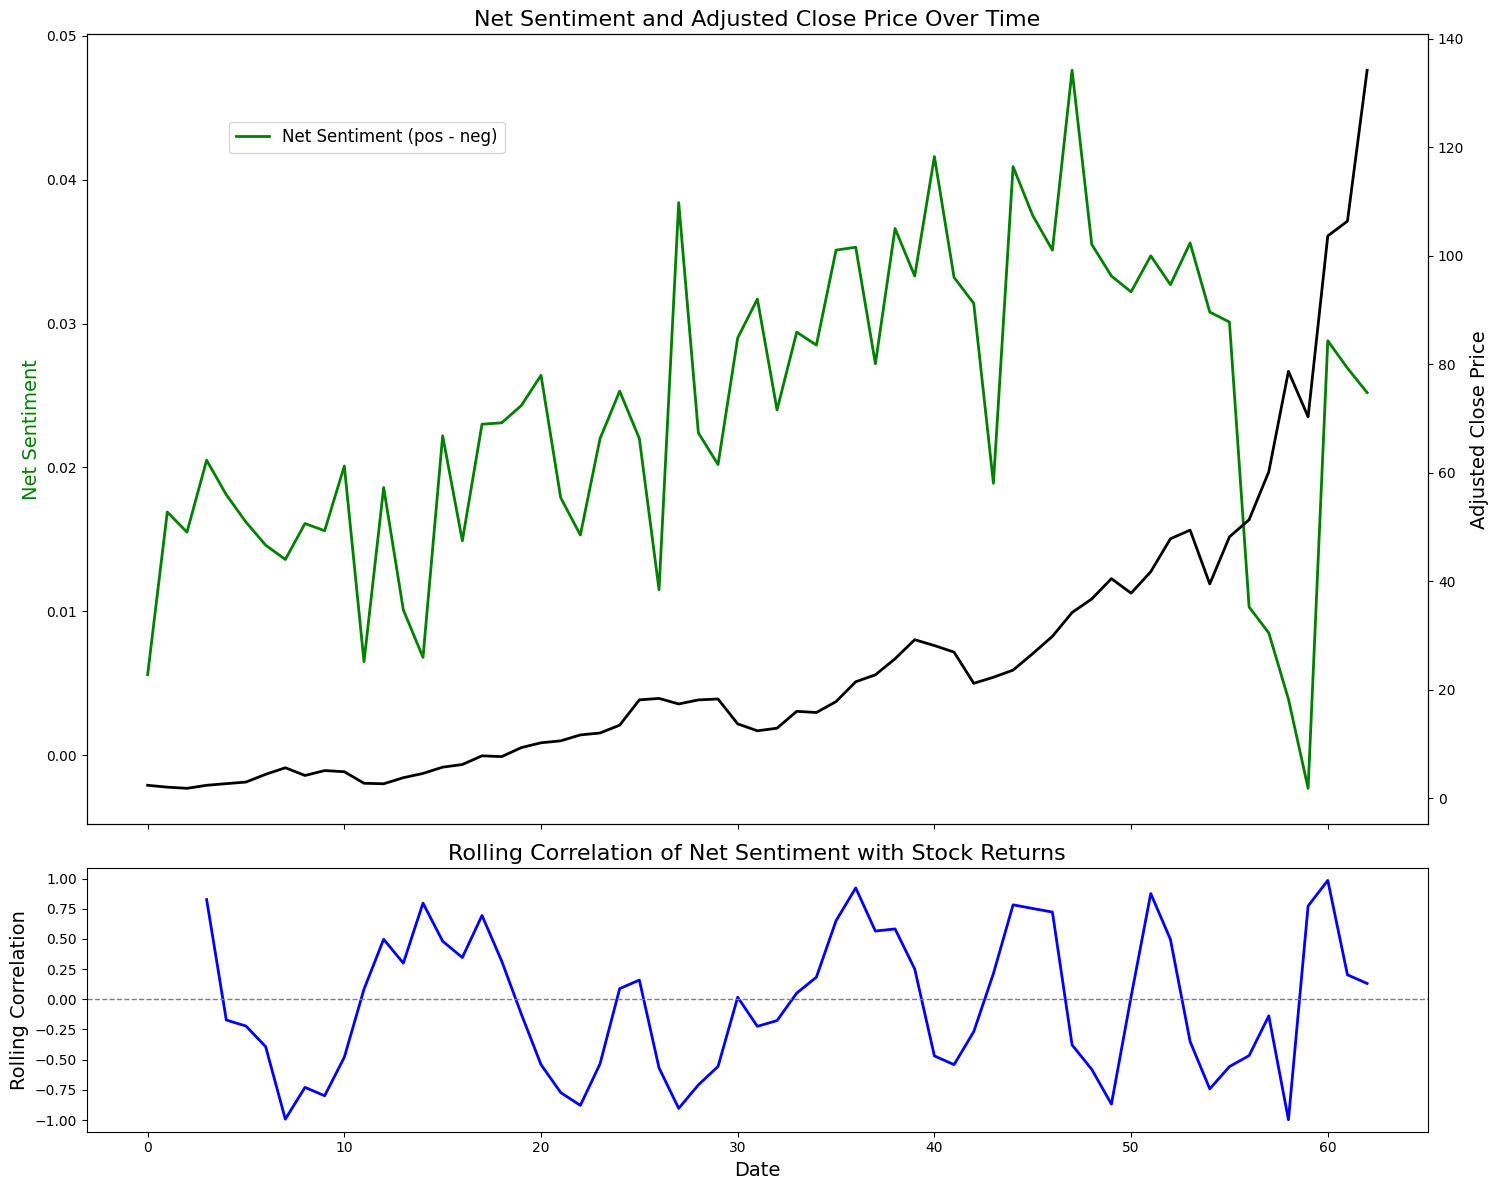

In [74]:


# Step 2: Calculate rolling correlation between net_sentiment and returns
# Since we have quarterly data, we use a rolling window of 4 periods (4 quarters = 1 year)
window_size = 4  # 4 quarters (1 year) rolling window for quarterly data
rolling_corr_net_sent = df_technology['returns'].rolling(window_size).corr(df_technology['net_sentiment'])

# Step 3: Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plotting Net Sentiment and Adjusted Close Price in the first subplot
ax1.plot(df_technology.index, df_technology['net_sentiment'], color='green', label='Net Sentiment (pos - neg)', linewidth=2)
ax1.set_ylabel('Net Sentiment', color='green', fontsize=14)

# Creating a second y-axis on the first subplot for Adjusted Close Price
ax1_twin = ax1.twinx()
ax1_twin.plot(df_technology.index, df_technology['Adj Close'], color='black', label='Adjusted Close Price', linewidth=2)
ax1_twin.set_ylabel('Adjusted Close Price', color='black', fontsize=14)

# Title for the first subplot
ax1.set_title('Net Sentiment and Adjusted Close Price Over Time', fontsize=16)

# Adding a legend
ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), fontsize=12)

# Step 4: Plot the rolling correlation in the second subplot
ax2.plot(df_technology.index, rolling_corr_net_sent, label='Rolling Correlation (Net Sentiment and Returns)', color='blue', linewidth=2)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Rolling Correlation', fontsize=14)
ax2.set_title('Rolling Correlation of Net Sentiment with Stock Returns', fontsize=16)

# Add a horizontal line at 0 correlation for reference
ax2.axhline(0, color='grey', linewidth=1, linestyle='--')

# Adjust the layout to avoid overlap
plt.tight_layout()

plt.show()

In [76]:
df_aapl[['net_sentiment', 'returns']].describe()

,net_sentiment,returns
count,63.000000,63.000000
mean,0.023908,0.113722
std,0.010510,1.927318
min,-0.002300,-6.312981
25%,0.016150,-0.333001
50%,0.024000,0.105257
75%,0.032450,0.696629
max,0.047600,9.823135
